Script to test and find velocity threshold for resuspenssion :D

In [3]:
%matplotlib inline
import sys
import random
import xarray as xr
import numpy as np
import os
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import glob
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from cartopy import crs, feature

sys.path.append('/ocean/vvalenzuela/MOAD/Ocean_Parcels')

from OP_functions import *

import cmocean
cmap = cmocean.cm.deep

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [1]:
import useful_params
import mapitas

In [4]:
file_name = '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs/Test_hourly_V2/PBDEs_run_for_4_days_5_hourly_particles_20220101_1n_20220105_1n.zarr'
#file_name = '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs/Test_hourly_V2/PBDEs_run_for_7_days_15_hourly_particles_20220101_1n_20220108_1n.zarr'
ds = xr.open_zarr(file_name, decode_times=True)


In [6]:
ds.initialized[0,:].values

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

In [119]:
days_release = 1
n_release = 5
v_len = 24*days_release
matriz_horas = np.arange(0,v_len)

In [120]:
idx = np.arange(n_release, n_release*v_len +1, n_release)

In [121]:
N_obs = v_len
ds_subset = ds.isel(obs=slice(0, N_obs))
# mask
traj = np.arange(len(ds.trajectory))[:, None]
mask = traj >= idx
#
ds_subset = ds_subset.where(~mask)
data_analysis = xr.concat([ds_subset, ds.isel(obs=slice(N_obs, -1))], dim="obs")

In [122]:
tt = []
for i in range(0,len(data_analysis.obs)):
    tt.append(np.min(data_analysis.time[0,0].values).astype('datetime64[s]').tolist() + i*timedelta(hours=1))
times = np.tile(tt, (len(data_analysis.trajectory), 1))
#
data_analysis['time'].values = times

In [127]:
file_save = '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs/Test_hourly_V2/PBDEs_run_for_7_days_15_hourly_particles_20220101_1n_20220108_1n.zarr'
data_analysis.to_zarr(file_save, mode = 'w')

In [124]:
xr.open_dataset(file_save)

<xarray.Dataset> Size: 2MB
Dimensions:      (trajectory: 360, obs: 119)
Coordinates:
  * obs          (obs) int32 476B 24 25 26 27 28 29 ... 137 138 139 140 141 142
  * trajectory   (trajectory) int64 3kB 360 361 362 363 364 ... 716 717 718 719
Data variables:
    fact         (trajectory, obs) float32 171kB ...
    initialized  (trajectory, obs) float32 171kB ...
    lat          (trajectory, obs) float64 343kB ...
    lon          (trajectory, obs) float64 343kB ...
    n            (trajectory, obs) float32 171kB ...
    status       (trajectory, obs) float32 171kB ...
    time         (trajectory, obs) datetime64[ns] 343kB ...
    wa           (trajectory, obs) float32 171kB ...
    wm           (trajectory, obs) float32 171kB ...
    z            (trajectory, obs) float64 343kB ...
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        MPParticlePBDEs_statesPBDEs_formsAdvectionturb_mi...
    parcels_mesh:           spherical
    parcels_version:        3.0.5

In [74]:
data = data_analysis
#
colloidal = []
marine = []
bottom = []
sewage = []
total = []
#
for i in range(len(data.obs)):
    len_1 = len(np.where(np.isfinite(data.status[:, i]) & (data.status[:, i] == 1.))[0])
    len_2 = len(np.where(np.isfinite(data.status[:, i]) & (data.status[:, i] == 2.))[0])
    len_3 = len(np.where(np.isfinite(data.status[:, i]) & (data.status[:, i] == 3.))[0])
    len_4 = len(np.where(np.isfinite(data.status[:, i]) & (data.status[:, i] == 4.))[0])
    #
    len_T = np.count_nonzero(~np.isnan(data.status[:, i]))
    #
    sewage.append(len_1)
    colloidal.append(len_2)
    marine.append(len_3)
    bottom.append(len_4)
    total.append(len_T)
#    
proportion_colloidal = np.array(colloidal)/np.array(total)
proportion_marine = np.array(marine)/np.array(total)
proportion_bottom = np.array(bottom)/np.array(total)
proportion_sewage = np.array(sewage)/np.array(total)
#

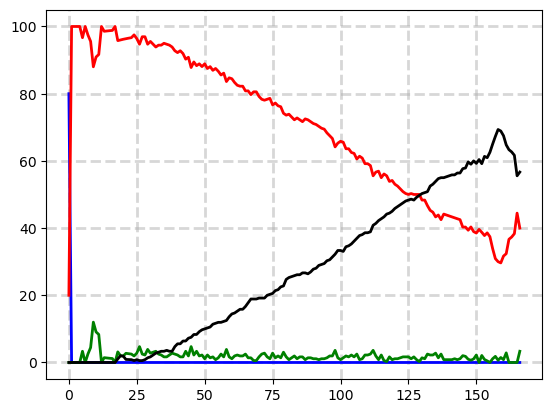

In [75]:
plt.plot(proportion_sewage*100, 'b', label = 'S. Particle (SP)', linewidth = 2)
plt.plot(proportion_colloidal*100, 'r', label = 'Colloidal (C)', linewidth = 2)
plt.plot(proportion_marine*100, 'g', label = 'M. Particle (MP)', linewidth = 2)
plt.plot(proportion_bottom*100, 'k', label = 'At Bottom (B)', linewidth = 2)
#ax4.set_xlabel('Time (through simulation)', fontsize=20)
plt.grid(linestyle = '--', alpha = 0.5, linewidth = 2)
#plt.ylim(0,100)

In [77]:
limit_begin_end = int(timedelta(days=1).total_seconds()/(60*60))
#
data_analysis = ds.isel(obs=slice(limit_begin_end, -limit_begin_end))
tt = []
for i in range(0,len(data_analysis.obs)):
    tt.append(np.min(data_analysis.time[0,0].values).astype('datetime64[s]').tolist() + i*timedelta(hours=1))
times = np.tile(tt, (len(data_analysis.trajectory), 1))
#
data_analysis['time'].values = times
#data = xr.open_zarr('/home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs/Test_hourly_V2/PBDEs_run_for_9_days_15_hourly_particles_20220101_1n_20220110_1n.zarr')
#depth = data.z/data.fact

In [7]:
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
tmask = 1 - mesh.tmask[0]
#
path_months = '/results2/SalishSea/month-avg.202111/'
path_days_h = '/results2/SalishSea/nowcast-green.202111/'

Load the necessary fields

In [8]:
path_bat = '/ocean/vvalenzuela/MOAD/grid2/mesh_mask202108_TDV.nc'
bat_file = xr.open_dataset(path_bat)
mbathy = bat_file['mbathy'][0]

In [9]:
#
def get_timestamps(start,length):
    timestamps=[]
    duration = timedelta(days=length)
    for day in range(duration.days):
        timestamps.append([start + timedelta(days=day)])
    return timestamps

In [10]:
begin = datetime(2015,8,6)
end = datetime(2015,9,6)
#end = datetime(2016,3,10)
t_len = (end - begin).days
#
dates = get_timestamps(begin,t_len)

In [11]:
def date_files(date, path, prefix_type= 'grid_T.nc'):
    folder = date.strftime("%d%b%y").lower()
    prefix = os.path.join(path, folder + f'/SalishSea_1h_{date.strftime("%Y%m%d").lower()}_{date.strftime("%Y%m%d").lower()}_{prefix_type}*')
    file_name = glob.glob(prefix) 
    return file_name

In [12]:
path_days_h = '/results2/SalishSea/nowcast-green.202111/'
files_e3t = []
for i in range(t_len):
    files_e3t.append(date_files(dates[i][0],path_days_h, prefix_type = 'grid_T.nc'))
    #
files_U = []
for i in range(t_len):
    files_U.append(date_files(dates[i][0],path_days_h, prefix_type = 'grid_U.nc'))
    #
files_V = []
for i in range(t_len):
    files_V.append(date_files(dates[i][0],path_days_h, prefix_type = 'grid_V.nc'))

In [13]:
e3t = xr.open_dataset(files_e3t[0][0])['e3t']

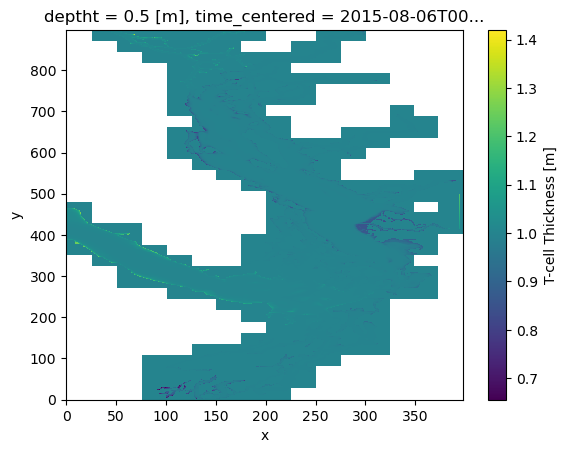

In [14]:
e3t[0][0].plot()

In [15]:
e3t_min = e3t.min() / 2
e3t_max = e3t.max() / 2

In [16]:
u_vel = xr.open_dataset(files_U[0][0])['vozocrtx']
v_vel = xr.open_dataset(files_V[0][0])['vomecrty']

$$u^{*} = \frac{U \cdot k}{ln(\frac{z}{z_{*}})}$$

$$\tau = u*^{2} \cdot \rho $$

The min value of e3t will describe a 'shallower' point with high velocities, while the max value of e3t will describe a deeper point further down the water column. So, if we get a sense of what range of Tau and velocities values we can find, we can then get t threshold velocity...avoiding extra calculations and loops within the Resuspension  Kernel

In [17]:
U = np.linspace(0, u_vel.max().values,10000)
V = np.linspace(0, v_vel.max().values,10000)
H_component = (U ** 2 + V ** 2) ** (1/2)

In [18]:
TAU_max = (H_component ** 2) * (0.42 ** 2) * ((np.log(e3t_min.values) - np.log(0.07)) ** (-2)) * 1024
TAU_min = (H_component ** 2) * (0.42 ** 2) * ((np.log(e3t_max.values) - np.log(0.07)) ** (-2)) * 1024

In [19]:
t_threshold = 0.05

In [20]:
idx_min = min(range(len(TAU_min)), key=lambda i: abs(TAU_min[i] - t_threshold))
idx_max = min(range(len(TAU_max)), key=lambda i: abs(TAU_max[i] - t_threshold))

Text(0.5, 0.98, 'Bottom Stress Threshold $\\tau _{threshold}$ = 0.05')

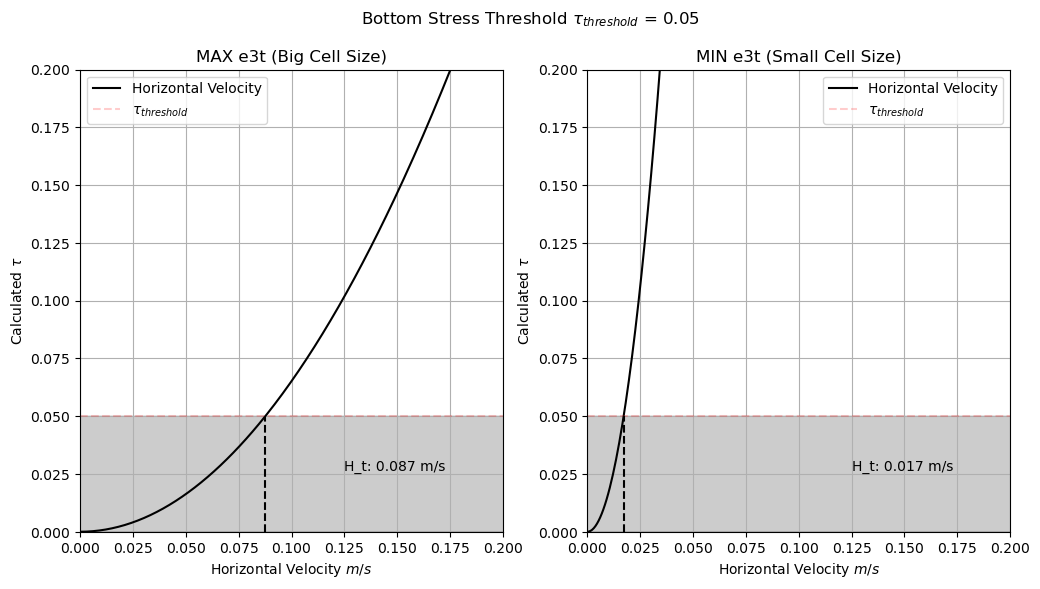

In [21]:
fig, ax = plt.subplots(1,2,figsize = (12,6))
ax[0].plot(H_component,TAU_min, 'k', label = 'Horizontal Velocity')
ax[0].vlines(x=H_component[idx_min], ymin=0, ymax = t_threshold, linestyle = '--', colors = 'k')
ax[0].text(0.125, 0.025, f"H_t: {np.round(H_component[idx_min],3)} m/s", color = 'k', fontsize=10, ha='left', va='bottom')
ax[0].hlines(y=t_threshold, xmin = 0, xmax = 1, colors = 'r', label=r'$\tau _{threshold}$', linestyle = '--', alpha = .2)
ax[0].fill_between(x=H_component, y1=0, y2=t_threshold, alpha = .2, color = 'k')
ax[0].set_ylim([0,t_threshold*4])
ax[0].set_xlim([0,.2])
ax[0].legend()
ax[0].grid()
ax[0].set_ylabel(r'Calculated $\tau$')
ax[0].set_xlabel(r'Horizontal Velocity $m/s$')
ax[0].set_title('MAX e3t (Big Cell Size)')
#
ax[1].plot(H_component,TAU_max, 'k', label = 'Horizontal Velocity')
ax[1].hlines(y=t_threshold, xmin = 0, xmax = 1, colors = 'r', label=r'$\tau _{threshold}$', linestyle = '--', alpha = .2)
ax[1].vlines(x=H_component[idx_max], ymin=0, ymax = t_threshold, linestyle = '--', colors = 'k')
ax[1].text(0.125, 0.025, f"H_t: {np.round(H_component[idx_max],3)} m/s", color = 'k', fontsize=10, ha='left', va='bottom')
ax[1].fill_between(x=U, y1=0, y2=t_threshold, alpha = .2, color = 'k')
ax[1].set_ylim([0,t_threshold*4])
ax[1].set_xlim([0,.2])
ax[1].legend()
ax[1].grid()
ax[1].set_ylabel(r'Calculated $\tau$')
ax[1].set_xlabel(r'Horizontal Velocity $m/s$')
ax[1].set_title('MIN e3t (Small Cell Size)')
#
plt.suptitle(r'Bottom Stress Threshold $\tau _{threshold}$ = ' + str(t_threshold))

Text(0.5, 0.98, 'Bottom Stress Threshold $\\tau _{threshold}$ = 0.05')

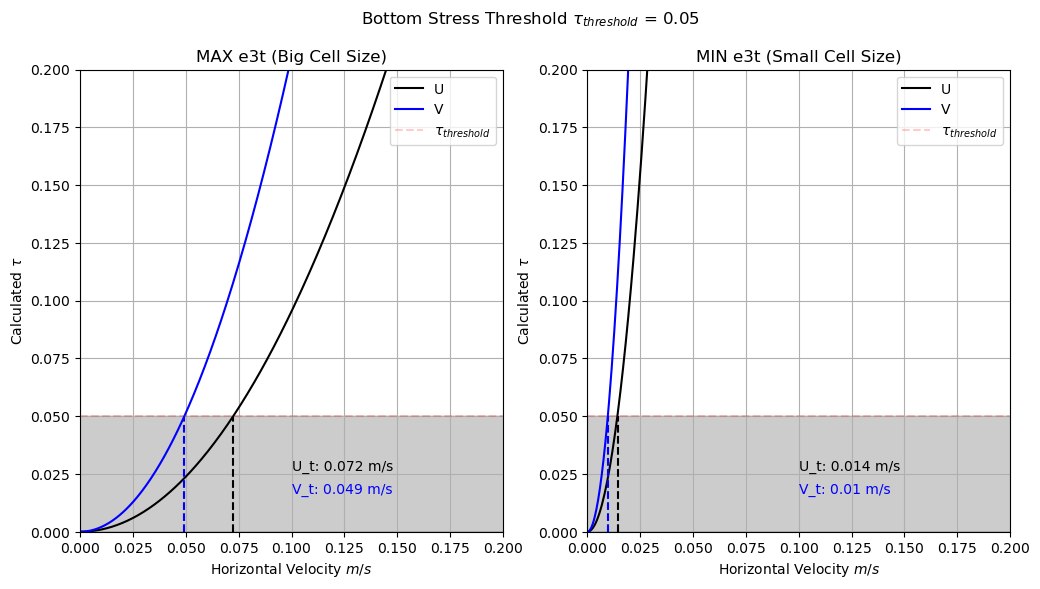

In [22]:
fig, ax = plt.subplots(1,2,figsize = (12,6))
ax[0].plot(U,TAU_min, 'k', label = 'U')
ax[0].plot(V,TAU_min, 'b', label = 'V')
ax[0].vlines(x=U[idx_min], ymin=0, ymax = t_threshold, linestyle = '--', colors = 'k')
ax[0].vlines(x=V[idx_min], ymin=0, ymax = t_threshold, linestyle = '--', colors = 'b')
ax[0].text(0.1, 0.025, f"U_t: {np.round(U[idx_min],3)} m/s", color = 'k', fontsize=10, ha='left', va='bottom')
ax[0].text(0.1, 0.015, f"V_t: {np.round(V[idx_min],3)} m/s", color = 'b', fontsize=10, ha='left', va='bottom')
ax[0].hlines(y=t_threshold, xmin = 0, xmax = 1, colors = 'r', label=r'$\tau _{threshold}$', linestyle = '--', alpha = .2)
ax[0].fill_between(x=U, y1=0, y2=t_threshold, alpha = .2, color = 'k')
ax[0].set_ylim([0,t_threshold*4])
ax[0].set_xlim([0,.2])
ax[0].legend()
ax[0].grid()
ax[0].set_ylabel(r'Calculated $\tau$')
ax[0].set_xlabel(r'Horizontal Velocity $m/s$')
ax[0].set_title('MAX e3t (Big Cell Size)')
#
ax[1].plot(U,TAU_max, 'k', label = 'U')
ax[1].plot(V,TAU_max, 'b', label = 'V')
ax[1].hlines(y=t_threshold, xmin = 0, xmax = 1, colors = 'r', label=r'$\tau _{threshold}$', linestyle = '--', alpha = .2)
ax[1].vlines(x=U[idx_max], ymin=0, ymax = t_threshold, linestyle = '--', colors = 'k')
ax[1].vlines(x=V[idx_max], ymin=0, ymax = t_threshold, linestyle = '--', colors = 'b')
ax[1].text(0.1, 0.025, f"U_t: {np.round(U[idx_max],3)} m/s", color = 'k', fontsize=10, ha='left', va='bottom')
ax[1].text(0.1, 0.015, f"V_t: {np.round(V[idx_max],3)} m/s", color = 'b', fontsize=10, ha='left', va='bottom')
ax[1].fill_between(x=U, y1=0, y2=t_threshold, alpha = .2, color = 'k')
ax[1].set_ylim([0,t_threshold*4])
ax[1].set_xlim([0,.2])
ax[1].legend()
ax[1].grid()
ax[1].set_ylabel(r'Calculated $\tau$')
ax[1].set_xlabel(r'Horizontal Velocity $m/s$')
ax[1].set_title('MIN e3t (Small Cell Size)')
#
plt.suptitle(r'Bottom Stress Threshold $\tau _{threshold}$ = ' + str(t_threshold))

Velocity values below these ones for the min and max e3t, will NOT resuspend. But, values above these ones for the min and max e3t, will resuspend :D